In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.widgets import Slider
from scipy.optimize import curve_fit

import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, Output, RadioButtons

from numpy.polynomial import Chebyshev

from scipy.special import erf
import time  # Import the time module

# Workflow for Color Fringe Computation and Chromatic Correction
This document outlines the steps needed to simulate chromatic aberration effects, including data import, interpolation, interactive curve fitting, and analysis of color fringe width. The simulation takes into account the physics of chromatic aberration, sensor response, and overexposure effects.

## 1. Data Import

In [2]:
# CHLzf85 data points
# Each row contains [wavelength (nm), defocus (µm)]
CHLzf85 = np.array([
    [400.0, 285.0],
    [410.0, 190.0],
    [420.0, 118.0],
    [430.0, 63.0],
    [440.0, 22.0],
    [450.0, -9.0],
    [460.0, -31.0],
    [470.0, -46.0],
    [480.0, -56.0],
    [490.0, -62.0],
    [500.0, -64.0],
    [510.0, -63.0],
    [520.0, -60.0],
    [530.0, -54.0],
    [540.0, -48.0],
    [550.0, -39.0],
    [560.0, -30.0],
    [570.0, -20.0],
    [580.0, -9.0],
    [590.0, 3.0],
    [600.0, 15.0],
    [610.0, 28.0],
    [620.0, 41.0],
    [630.0, 54.0],
    [640.0, 68.0],
    [650.0, 82.0],
    [660.0, 96.0],
    [670.0, 111.0],
    [680.0, 125.0],
    [690.0, 139.0],
    [700.0, 156.0]
])

In [3]:
# Light Source Data
# Each row contains [wavelength (nm), daylight value]
or_Daylight = np.array([
    [380, 11],
    [390, 16],
    [400, 22],
    [410, 33],
    [420, 48],
    [430, 62],
    [440, 71],
    [450, 78],
    [460, 84],
    [470, 92],
    [480, 97],
    [490, 100],
    [500, 96],
    [510, 95],
    [520, 95],
    [530, 94],
    [540, 90],
    [550, 78],
    [560, 70],
    [570, 78],
    [580, 88],
    [590, 94],
    [600, 91],
    [610, 85],
    [620, 82],
    [630, 85],
    [640, 92],
    [650, 100],
    [660, 89],
    [670, 76],
    [680, 83],
    [690, 100]
])

# Optional: Print the shape and first few rows for verification
print("Original Daylight Spectrum shape:", or_Daylight.shape)

Original Daylight Spectrum shape: (32, 2)


In [4]:
# Sensor data for each channel:
# Each row contains [wavelength (nm), sensitivity]
SensorBlue = np.array([
    [400., 0.42],
    [410., 9.08],
    [420., 24.34],
    [430., 28.37],
    [440., 40.12],
    [450., 39.01],
    [460., 47.12],
    [470., 46.65],
    [480., 41.14],
    [490., 26.73],
    [500., 14.75],
    [510., 7.55],
    [520., 2.76],
    [530., 0.],
    [540., 0.],
    [550., 0.],
    [560., 0.],
    [570., 0.],
    [580., 0.],
    [590., 0.],
    [600., 0.],
    [610., 0.],
    [620., 0.],
    [630., 0.],
    [640., 0.],
    [650., 0.],
    [660., 0.69],
    [670., 0.84],
    [680., 0.32],
    [690., 0.04],
    [700., 0.]
])

SensorGreen = np.array([
    [400., 0.],
    [410., 0.],
    [420., 0.],
    [430., 0.],
    [440., 0.],
    [450., 0.],
    [460., 0.],
    [470., 4.63],
    [480., 6.48],
    [490., 9.09],
    [500., 17.75],
    [510., 28.39],
    [520., 37.8],
    [530., 38.39],
    [540., 35.02],
    [550., 28.83],
    [560., 28.1],
    [570., 19.02],
    [580., 13.1],
    [590., 6.96],
    [600., 4.33],
    [610., 3.34],
    [620., 3.02],
    [630., 0.],
    [640., 0.],
    [650., 0.],
    [660., 0.69],
    [670., 0.7],
    [680., 0.34],
    [690., 0.05],
    [700., 0.]
])

SensorRed = np.array([
    [400., 0.],
    [410., 1.3],
    [420., 1.86],
    [430., 2.17],
    [440., 1.73],
    [450., 0.],
    [460., 0.],
    [470., 0.],
    [480., 0.],
    [490., 0.],
    [500., 0.],
    [510., 0.],
    [520., 0.],
    [530., 0.],
    [540., 0.],
    [550., 0.],
    [560., 0.],
    [570., 2.38],
    [580., 60.18],
    [590., 100.],
    [600., 92.73],
    [610., 72.75],
    [620., 50.6],
    [630., 35.81],
    [640., 35.08],
    [650., 22.4],
    [660., 16.96],
    [670., 7.75],
    [680., 3.3],
    [690., 0.78],
    [700., 0.18]
])

# Optional: Print sensor data shapes to confirm successful import
print("SensorBlue shape:", SensorBlue.shape)
print("SensorGreen shape:", SensorGreen.shape)
print("SensorRed shape:", SensorRed.shape)

SensorBlue shape: (31, 2)
SensorGreen shape: (31, 2)
SensorRed shape: (31, 2)


## 2. Data Fitting and Common Sampling Scheme

In [5]:
# CHL fit: polynomial of degree 6

# x_CHL contains the wavelength values and y_CHL the corresponding CHL values from the dataset CHLzf85.
x_CHL = CHLzf85[:, 0]
y_CHL = CHLzf85[:, 1]

# Fit a 6th-degree polynomial to the CHL data
CHL_coeffs = np.polyfit(x_CHL, y_CHL, 6)

# Define a function to evaluate the fitted polynomial at any given x (wavelength)
def CHLFit(x):
    # np.polyval evaluates the polynomial for the input x using coefficients in descending order
    return np.polyval(CHL_coeffs, x)

# Optional: Print the coefficients for inspection
print("Fitted CHL coefficients:", CHL_coeffs)

x_fit = np.linspace(400, 700, 300)
CHL_fit = CHLFit(x_fit)
print("Fitted CHL shape:", CHL_fit.shape)

Fitted CHL coefficients: [ 6.17055255e-12 -2.17284405e-08  3.18690992e-05 -2.49424071e-02
  1.09994225e+01 -2.59404221e+03  2.55683162e+05]
Fitted CHL shape: (300,)


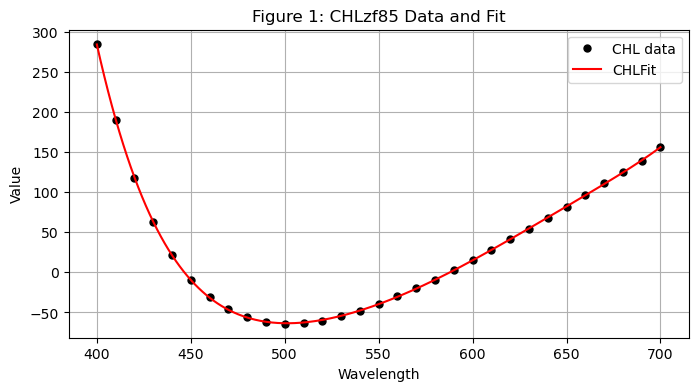

In [6]:
# Figure 1: CHLzf85 plot (points and line)
plt.figure(figsize=(8, 4))
plt.plot(x_CHL, y_CHL, 'o', markersize=5, color='black', label='CHL data') # Points in black

plt.plot(x_fit, CHL_fit, '-', color='red', label='CHLFit') # Curve in red
plt.title('Figure 1: CHLzf85 Data and Fit')
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Light Source Fit: polynomial of degree 6 and resampling

def resample_spectrum_poly(spectrum, new_wavelengths, degree=6):
    # Separate the wavelength and intensity data
    wavelengths = spectrum[:, 0]
    intensities = spectrum[:, 1]
    
    # Fit a polynomial of the given degree to the data
    coeffs = np.polyfit(wavelengths, intensities, degree)
    poly_func = np.poly1d(coeffs)
    
    # Evaluate the polynomial at the new wavelengths
    new_intensities = poly_func(new_wavelengths)

    # Normalize the intensities so that the maximum is 100
    max_intensity = np.max(new_intensities)
    new_intensities = new_intensities / max_intensity * 100
    
    return np.column_stack((new_wavelengths, new_intensities))

# Resample the spectrum using a 6th-degree polynomial fit
Daylight = resample_spectrum_poly(or_Daylight, x_CHL, degree=6)

# Print the resampled spectrum
print("Resampled Daylight Spectrum:", Daylight.shape)

Resampled Daylight Spectrum: (31, 2)


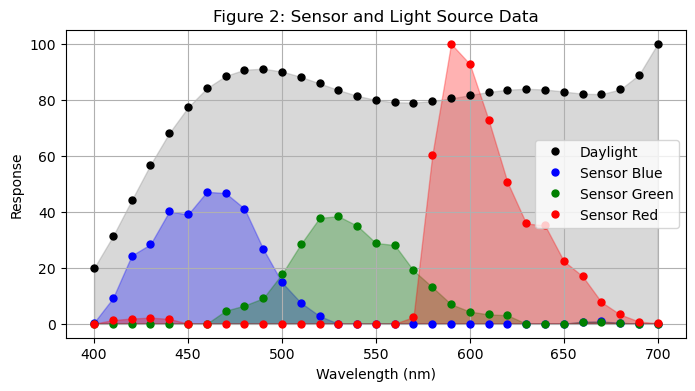

In [8]:
# Figure 2: Sensor response and light source spectrum (points and line)

plt.figure(figsize=(8, 4))

# Plot the Daylight spectrum (assumed to be stored in the 'Daylight' variable)
# 'o' markers are used for the data points, with black color.
plt.plot(Daylight[:,0], Daylight[:,1], 'o', markersize=5, color='black', label='Daylight')
# Fill the area under the Daylight curve with a light gray color
plt.fill_between(Daylight[:,0], Daylight[:,1], color='gray', alpha=0.3)

# Plot the Sensor Blue data using blue markers and line
plt.plot(SensorBlue[:,0], SensorBlue[:,1], 'o', markersize=5, color='blue', label='Sensor Blue')
# Fill the area under the Sensor Blue curve with a blue color
plt.fill_between(SensorBlue[:,0], SensorBlue[:,1], color='blue', alpha=0.3)

# Plot the Sensor Green data using green markers and line
plt.plot(SensorGreen[:,0], SensorGreen[:,1], 'o', markersize=5, color='green', label='Sensor Green')
# Fill the area under the Sensor Green curve with a green color
plt.fill_between(SensorGreen[:,0], SensorGreen[:,1], color='green', alpha=0.3)

# Plot the Sensor Red data using red markers and line
plt.plot(SensorRed[:,0], SensorRed[:,1], 'o', markersize=5, color='red', label='Sensor Red')
# Fill the area under the Sensor Red curve with a red color
plt.fill_between(SensorRed[:,0], SensorRed[:,1], color='red', alpha=0.3)

plt.title('Figure 2: Sensor and Light Source Data')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Extract wavelengths and daylight intensity
wavelengths = Daylight[:, 0]
daylight_intensity = Daylight[:, 1]

# Define a helper function to compute normalization factor for a given sensor channel
def compute_norm(sensor):
    sensor_response = sensor[:, 1]
    # Compute the integral using the composite trapezoidal rule
    integral = np.trapezoid(sensor_response * daylight_intensity, x=wavelengths)
    norm_factor = 1 / integral if integral != 0 else 0
    return norm_factor, integral

# Compute normalization factors for each sensor
norm_factor_blue, integral_blue = compute_norm(SensorBlue)
norm_factor_green, integral_green = compute_norm(SensorGreen)
norm_factor_red, integral_red = compute_norm(SensorRed)

# Apply normalization: each normalized sensor response satisfies
# ∫ [NormalizedSensor(λ) * DaylightIntensity(λ)] dλ = 1
SensorBlue_norm = SensorBlue.copy()
SensorGreen_norm = SensorGreen.copy()
SensorRed_norm = SensorRed.copy()

SensorBlue_norm[:, 1] *= norm_factor_blue
SensorGreen_norm[:, 1] *= norm_factor_green
SensorRed_norm[:, 1] *= norm_factor_red

# Optionally, verify the integrals are now ~1 using np.trapezoid
blue_integral_norm = np.trapezoid(SensorBlue_norm[:, 1] * daylight_intensity, x=wavelengths)
green_integral_norm = np.trapezoid(SensorGreen_norm[:, 1] * daylight_intensity, x=wavelengths)
red_integral_norm = np.trapezoid(SensorRed_norm[:, 1] * daylight_intensity, x=wavelengths)

print("Normalized Blue sensor integral:", blue_integral_norm)
print("Normalized Green sensor integral:", green_integral_norm)
print("Normalized Red sensor integral:", red_integral_norm)

Normalized Blue sensor integral: 1.0
Normalized Green sensor integral: 1.0000000000000002
Normalized Red sensor integral: 1.0000000000000004


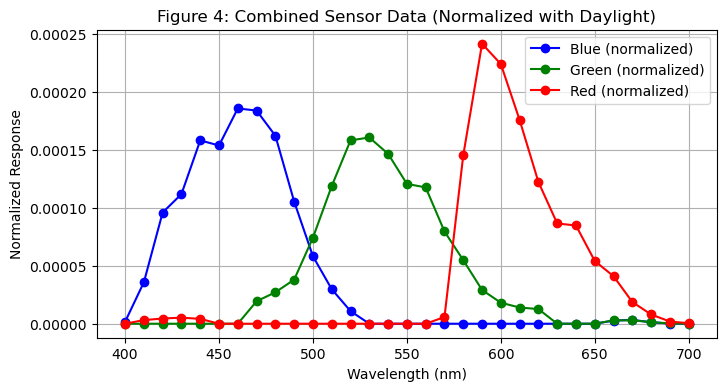

In [10]:
# Figure 4: Final Combined Sensor Plot (overlaid) with Normalization

plt.figure(figsize=(8, 4))

plt.plot(wavelengths, SensorBlue_norm[:, 1], 'o-', color='blue', label='Blue (normalized)')
plt.plot(wavelengths, SensorGreen_norm[:, 1], 'o-', color='green', label='Green (normalized)')
plt.plot(wavelengths, SensorRed_norm[:, 1], 'o-', color='red', label='Red (normalized)')

plt.title('Figure 4: Combined Sensor Data (Normalized with Daylight)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Response')
plt.legend()
plt.grid(True)
plt.show()

## 3. CHL Curve Modification and Visualization

In [11]:
# Cell 1: Core Functions & Global Array Access
# -------------------------------------------------
# Make sure that x_fit, CHLFit, x_CHL, y_CHL, and CHL_fit are defined in your environment.

# Compute the wavelength interval (dx)
dx = x_fit[1] - x_fit[0]

# Find the original lowest point on the CHL curve (in the 400–700 nm range)
x_min = x_fit[np.argmin(CHL_fit)]
y_min = np.min(CHL_fit)
print("Original lowest point at x = {:.2f} nm, y = {:.2f}".format(x_min, y_min))

def CHLFit_mod_overall(x_vals, x_shift=0.0, tilt=0.0):
    """
    Returns the modified CHL curve with opposite tilts applied to each side of the pivot.
    """
    pivot_x = x_min + x_shift
    pivot_y = CHLFit(x_min)
    
    # Compute the horizontally shifted base curve.
    x_shifted = x_vals - x_shift
    base = CHLFit(x_shifted)
    
    # Compute numerical derivative.
    dbase = np.gradient(base, dx)
    
    # Apply opposite tilt factors depending on side relative to the pivot.
    new_deriv = np.empty_like(dbase)
    for i, x in enumerate(x_vals):
        if x < pivot_x:
            new_deriv[i] = dbase[i] * (1 - tilt)
        else:
            new_deriv[i] = dbase[i] * (1 + tilt)
    
    # Integrate the new derivative.
    g = np.empty_like(x_vals)
    pivot_index = np.argmin(np.abs(x_vals - pivot_x))
    g[pivot_index] = pivot_y
    
    # Integrate forward from the pivot.
    for i in range(pivot_index + 1, len(x_vals)):
        g[i] = g[i - 1] + new_deriv[i - 1] * dx
    # Integrate backward from the pivot.
    for i in range(pivot_index - 1, -1, -1):
        g[i] = g[i + 1] - new_deriv[i + 1] * dx
        
    return g

def extract_sampled_modified_values_overall(x_shift=0.0, tilt=0.0):
    """
    Samples the modified CHL curve (with opposite tilts) every 10 nm between 400 and 700 nm.
    Returns a 2-column matrix: [wavelength, integer CHL value].
    """
    x_sample = np.arange(400, 701, 10)
    y_sample = CHLFit_mod_overall(x_sample, x_shift, tilt)
    y_sample_int = np.floor(y_sample)
    return np.column_stack((x_sample, y_sample_int))

# Global variable to store the sampled modified CHL values.
global_CHLfit = None

def get_modified_CHL_array(x_shift=0.0, tilt=0.0):
    """
    Computes and returns the global_CHLfit array given the input x_shift and tilt.
    This function can be called anywhere in your notebook.
    """
    global global_CHLfit
    global_CHLfit = extract_sampled_modified_values_overall(x_shift, tilt)
    return global_CHLfit

# Example call:
result = get_modified_CHL_array(x_shift=10, tilt=0.1)
print("Modified CHL array (global_CHLfit):")
print(result)

Original lowest point at x = 501.34 nm, y = -63.42
Modified CHL array (global_CHLfit):
[[400 302]
 [410 207]
 [420 133]
 [430  76]
 [440  33]
 [450   1]
 [460 -22]
 [470 -39]
 [480 -51]
 [490 -58]
 [500 -62]
 [510 -63]
 [520 -63]
 [530 -60]
 [540 -55]
 [550 -48]
 [560 -39]
 [570 -29]
 [580 -18]
 [590  -6]
 [600   6]
 [610  19]
 [620  32]
 [630  46]
 [640  60]
 [650  74]
 [660  89]
 [670 104]
 [680 119]
 [690 134]
 [700 150]]


In [12]:
# Cell 2: Interactive Plot and Array Update
# -------------------------------------------
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, interact, Output

def plot_CHL_overall(x_shift=0.0, tilt=0.0):
    """
    Plots the modified CHL curve with opposite tilts on each side of the pivot.
    """
    y_vals = CHLFit_mod_overall(x_fit, x_shift, tilt)
    
    plt.figure(figsize=(8, 4))
    plt.plot(x_fit, y_vals, label='Modified CHL Curve (Opposite Tilts)', lw=2)
    plt.scatter(x_CHL, y_CHL, color='red', label='Data Points')
    plt.scatter([x_min], [y_min], color='green', s=100, label='Original Lowest Point')
    plt.scatter([x_min + x_shift], [CHLFit(x_min)], color='blue', s=100, label='Shifted Pivot')
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('CHL Value')
    plt.title('Interactive CHL Curve with Opposite Tilts')
    plt.legend()
    plt.grid(True)
    plt.xlim(400, 700)
    plt.show()

# Define interactive sliders.
x_shift_slider = FloatSlider(min=-50, max=50, step=1, value=0, description='x Shift (nm)')
tilt_slider = FloatSlider(min=-0.5, max=0.5, step=0.01, value=0, description='Tilt Factor')

# Output area for interactive updates.
out = Output()

def update_display(x_shift, tilt):
    with out:
        out.clear_output(wait=True)
        # Display the interactive plot.
        plot_CHL_overall(x_shift, tilt)
        # Update and display the global_CHLfit array.
        updated_array = get_modified_CHL_array(x_shift, tilt)
        print("Updated global_CHLfit array:")
        print(updated_array)

# Create the interactive interface.
interact(update_display, x_shift=x_shift_slider, tilt=tilt_slider)
display(out)


interactive(children=(FloatSlider(value=0.0, description='x Shift (nm)', max=50.0, min=-50.0, step=1.0), Float…

Output()

### 3.2. Combination with Weighting Spectrum and Visualization

In [13]:
# Function converts a wavelength (in nanometers) from the visible spectrum into an approximate RGB color value.

def wavelength_to_rgb(wavelength, gamma=0.8):
    """
    Convert a given wavelength in nm to an RGB color.
    Based on the algorithm from Dan Bruton:
    http://www.efg2.com/Lab/ScienceAndEngineering/Spectra.htm
    """
    if 380 <= wavelength < 440:
        attenuation = 0.3 + 0.7*(wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif 440 <= wavelength < 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0 ** gamma
    elif 490 <= wavelength < 510:
        R = 0.0
        G = 1.0 ** gamma
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif 510 <= wavelength < 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0 ** gamma
        B = 0.0
    elif 580 <= wavelength < 645:
        R = 1.0 ** gamma
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif 645 <= wavelength <= 780:
        attenuation = 0.3 + 0.7*(780 - wavelength) / (780 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = G = B = 0.0

    return (R, G, B)

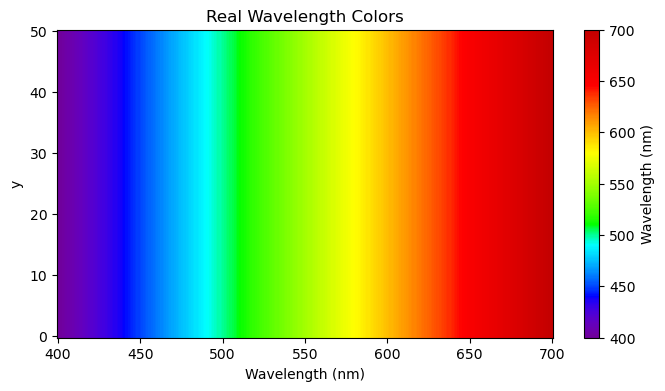

In [14]:
# Create a custom colormap from wavelengths 400 nm to 700 nm.
colormap_wavelengths = np.linspace(400, 700, 300)
colors = [wavelength_to_rgb(w) for w in colormap_wavelengths]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("wavelength_cmap", colors)

# --- Plot 1: DensityPlot Equivalent ---
# Create the grid and function values.
x_vals = np.linspace(400, 700, 300)
y_vals = np.linspace(0, 50, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X  # f(x,y) = x

plt.figure(figsize=(8, 4))
plt.pcolormesh(X, Y, Z, shading='auto', cmap=custom_cmap)
plt.colorbar(label='Wavelength (nm)')
plt.title('Real Wavelength Colors')
plt.xlabel('Wavelength (nm)')
plt.ylabel('y')
plt.show()

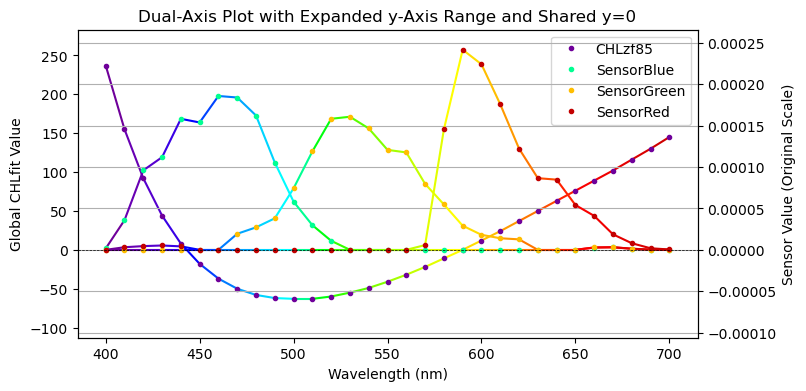

In [15]:
# Original global axis limits:
global_min, global_max = -80, 250
global_range = global_max - global_min
margin_global = 0.1 * global_range  # 10% margin

# Adjusted global limits with margin:
new_global_min = global_min - margin_global
new_global_max = global_max + margin_global

# Compute the fraction where zero lies on the global axis (with margin):
r = (0 - new_global_min) / (new_global_max - new_global_min)

# For sensor data, determine the maximum sensor value (across all sensor datasets).
sensor_max = max(SensorBlue_norm[:, 1].max(), SensorGreen_norm[:, 1].max(), SensorRed_norm[:, 1].max())
# Add a margin to the sensor_max (10% of sensor_max)
sensor_margin = 0.1 * sensor_max
sensor_max_new = sensor_max + sensor_margin

# Compute the sensor lower limit such that 0 lies at the same relative position.
sensor_min_new = - (r / (1 - r)) * sensor_max_new

# Prepare the figure with two y-axes.
fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

# Set the y-axis limits:
ax1.set_ylim(new_global_min, new_global_max)
ax2.set_ylim(sensor_min_new, sensor_max_new)

# Plot the global_CHLfit data on the primary axis (ax1).
x_vals = global_CHLfit[:, 0]
y_vals = global_CHLfit[:, 1]
norm = plt.Normalize(400, 700)
colors_mapped = custom_cmap(norm(x_vals))
# Draw the gradient line segments:
for j in range(len(x_vals) - 1):
    ax1.plot(x_vals[j:j+2], y_vals[j:j+2], color=colors_mapped[j])
# Plot uniform markers:
marker_color = custom_cmap(0 / 3)  # Using index 0 for global_CHLfit
ax1.plot(x_vals, y_vals, 'o', markersize=3, color=marker_color, label='CHLzf85')

# Plot the sensor datasets on the secondary axis (ax2).
sensor_datasets = [SensorBlue_norm, SensorGreen_norm, SensorRed_norm]
sensor_labels = ['SensorBlue', 'SensorGreen', 'SensorRed']
for i, (sensor, label) in enumerate(zip(sensor_datasets, sensor_labels), start=1):
    x_vals = sensor[:, 0]
    y_vals = sensor[:, 1]
    norm = plt.Normalize(400, 700)
    colors_mapped = custom_cmap(norm(x_vals))
    for j in range(len(x_vals) - 1):
        ax2.plot(x_vals[j:j+2], y_vals[j:j+2], color=colors_mapped[j])
    marker_color = custom_cmap(i / 3)  # Spread markers uniformly over the colormap
    ax2.plot(x_vals, y_vals, 'o', markersize=3, color=marker_color, label=label)

# Add horizontal lines at y=0 on both axes for clarity.
ax1.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')

# Set axis labels.
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Global CHLfit Value')
ax2.set_ylabel('Sensor Value (Original Scale)')

# Combine legends from both axes and position in upper right.
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Dual-Axis Plot with Expanded y-Axis Range and Shared y=0')
plt.grid(True)
plt.show()

## 4. Overexposure and Color Fringe Focus Calculation

In [16]:
# %% Cell 1: Imports and Data Setup
# Extract data channels
CHLdata = global_CHLfit[:, 1]
SensorBluedata = SensorBlue_norm[:, 1]
SensorGreendata = SensorGreen_norm[:, 1]
SensorReddata = SensorRed_norm[:, 1]

# Global constants and parameters
K = 1.4
xrange_val = 200    # Range for x values in plots
defocusrange = 1000
tol = 0.15

In [17]:
# %% Cell 2: Define Weighting Functions

def linear_PSF(x, ratio):
    if ratio < 1e-6:
        return 1 if x >= 0 else 0
    if x >= ratio:
        return 1
    elif x <= -ratio:
        return 0
    else:
        return 0.5 * (1 + x / ratio)

def gaussian_PSF(x, ratio):
    if ratio < 1e-6:
        return 1 if x >= 0 else 0
    return 0.5 * (1 + erf(x / (np.sqrt(2) * ratio)))

# Define aliases for weighting functions as used in interactive selection
ideal_weight = linear_PSF
gaussian_weight = gaussian_PSF


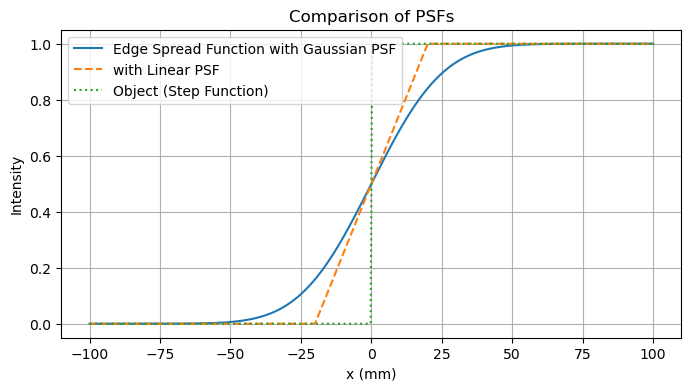

In [18]:
# %% Cell 3: PSF Comparison Plot

# Define a range of x values and a ratio parameter
x = np.linspace(-100, 100, 400)
ratio = 20  # adjust as needed

# Compute weights using the two functions
y_ideal = np.array([ideal_weight(val, ratio) for val in x])
y_gaussian = np.array([gaussian_weight(val, ratio) for val in x])

# Define the hard ideal step function
y_step = np.where(x < 0, 0, 1)

# Plot all three functions
plt.figure(figsize=(8, 4))
plt.plot(x, y_gaussian, label=r'Edge Spread Function with Gaussian PSF')
plt.plot(x, y_ideal, label='with Linear PSF', linestyle='--')
plt.plot(x, y_step, label='Object (Step Function)', linestyle=':')
plt.xlabel("x (mm)")
plt.ylabel("Intensity")
plt.title("Comparison of PSFs")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# %% Cell 4: Core Calculation Functions

def Exposure(x, F):
    """Generic edge function without spherical aberration."""
    return np.tanh(F * x) / np.tanh(F)

def compute_edge(x, z, F, g, sensor_data, weight_func):
    """Compute the edge response for a given sensor channel."""
    denom_factor = np.sqrt(4 * K**2 - 1)
    num = 0
    for n in range(len(CHLdata)):
        ratio = abs((z - CHLdata[n]) / denom_factor)
        weight = weight_func(x, ratio)
        num += sensor_data[n] * weight
    den = np.sum(sensor_data)
    return Exposure(num / den, F) ** g

def EdgeR(x, z, F, g, weight_func):
    """Edge function for the red channel."""
    return compute_edge(x, z, F, g, SensorReddata, weight_func)

def EdgeG(x, z, F, g, weight_func):
    """Edge function for the green channel."""
    return compute_edge(x, z, F, g, SensorGreendata, weight_func)

def EdgeB(x, z, F, g, weight_func):
    """Edge function for the blue channel."""
    return compute_edge(x, z, F, g, SensorBluedata, weight_func)


In [20]:
# %% Cell 5: Color Fringe and Binary Methods

def Farbsaum(x, z, F, g, weight_func):
    """Binary method to determine color fringe (Farbsaum)."""
    r = EdgeR(x, z, F, g, weight_func)
    g_val = EdgeG(x, z, F, g, weight_func)
    b = EdgeB(x, z, F, g, weight_func)
    if abs(r - b) > tol or abs(r - g_val) > tol or abs(g_val - b) > tol:
        return 1
    return 0

def Farbsaumbreite(z, F, g, weight_func):
    """Calculate overall color fringe width using the binary method."""
    xs = np.arange(-int(np.floor(xrange_val)), int(np.floor(xrange_val)) + 1)
    return np.sum([Farbsaum(x, z, F, g, weight_func) for x in xs])

def ColorFringe(x, z, F, g, weight_func):
    """Return an RGB tuple based on the edge functions."""
    return (EdgeR(x, z, F, g, weight_func),
            EdgeG(x, z, F, g, weight_func),
            EdgeB(x, z, F, g, weight_func))


In [21]:
# %% Cell 6: Plotting Functions and Interactive Update

def update_plots(z, F, gamma, model):
    """
    Update plots based on interactive parameters.
    
    Parameters:
        z : defocus value
        F : exposure factor
        gamma : gamma correction factor
        model : weighting model ('Ideal Weight' or 'Gaussian Weight')
    """
    # Choose the weighting function based on the model.
    weight_func = ideal_weight if model == 'Ideal Weight' else gaussian_weight

    # Create a figure with a GridSpec layout:
    # - Top left: Edge spread functions.
    # - Top right: Density plot from ColorFringe.
    # - Bottom: 2D spot diagram.
    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    # Top left: Edge spread functions.
    ax1 = fig.add_subplot(gs[0, 0])
    xs = np.linspace(-xrange_val, xrange_val, 400)
    edgeR_vals = np.array([EdgeR(x, z, F, gamma, weight_func) for x in xs])
    edgeG_vals = np.array([EdgeG(x, z, F, gamma, weight_func) for x in xs])
    edgeB_vals = np.array([EdgeB(x, z, F, gamma, weight_func) for x in xs])
    farb_vals = np.array([Farbsaum(x, z, F, gamma, weight_func) for x in xs])
    
    ax1.plot(xs, edgeR_vals, color=(1, 0, 0), label='EdgeR')
    ax1.plot(xs, edgeG_vals, color=(0, 1, 0), label='EdgeG')
    ax1.plot(xs, edgeB_vals, color=(0, 0, 1), label='EdgeB')
    ax1.plot(xs, farb_vals, color=(0.2, 0.2, 0.2), label='Farbsaum')
    ax1.set_title(f"Edge functions ({model} weighting)")
    ax1.set_xlabel("x")
    ax1.set_ylabel("Response")
    ax1.set_ylim(0, 1)
    ax1.legend()
    ax1.grid(True)
    
    # Top right: Density plot using ColorFringe (1D slice replicated vertically)
    ax2 = fig.add_subplot(gs[0, 1])
    X = np.linspace(-xrange_val, xrange_val, 200)
    Y = np.linspace(0, 0.5 * xrange_val, 100)
    XX, YY = np.meshgrid(X, Y)
    
    img = np.zeros((YY.shape[0], YY.shape[1], 3))
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            img[i, j, :] = ColorFringe(XX[i, j], z, F, gamma, weight_func)
    img = np.clip(img, 0, 1)
    ax2.imshow(img, extent=[-xrange_val, xrange_val, 0, 0.5 * xrange_val], aspect='auto')
    ax2.set_title("Density plot (ColorFringe)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    
    # Bottom: Spot diagram (2D)
    ax3 = fig.add_subplot(gs[1, :])
    grid_size = 100
    spot_range = np.linspace(-xrange_val/2, xrange_val/2, grid_size)
    X_spot, Y_spot = np.meshgrid(spot_range, spot_range)
    # Use the radial distance from the center for the effective x-value.
    R_spot = np.sqrt(X_spot**2 + Y_spot**2)
    
    spot_img = np.zeros((grid_size, grid_size, 3))
    for i in range(grid_size):
        for j in range(grid_size):
            spot_img[i, j, :] = ColorFringe(R_spot[i, j], z, F, gamma, weight_func)
    spot_img = np.clip(spot_img, 0, 1)
    ax3.imshow(spot_img, extent=[-xrange_val/2, xrange_val/2, -xrange_val/2, xrange_val/2])
    ax3.set_title("Spot Diagram")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    
    plt.tight_layout()
    plt.show()
    
    # Compute and print the overall color width using the binary method.
    width = Farbsaumbreite(z, F, gamma, weight_func)
    print("Color width (Binary method) =", width)


In [22]:
# %% Cell 7: Interactive Widget

# Create interactive widget to adjust parameters and update plots.
interact(update_plots,
         z=FloatSlider(min=-defocusrange, max=defocusrange, step=1, value=0, description="defocus"),
         F=FloatSlider(min=1, max=16, step=0.1, value=1, description="Exposure F"),
         gamma=FloatSlider(min=0.5, max=4, step=0.1, value=1, description="Gamma"),
         model=RadioButtons(options=['Ideal Weight', 'Gaussian Weight'], description='Model'));


interactive(children=(FloatSlider(value=0.0, description='defocus', max=1000.0, min=-1000.0, step=1.0), FloatS…

## 5. Through Focus Color Fringe Analysis

In [23]:
# %% Cell 8: Calculate Farbsaumbreite Data

import numpy as np

# Step size for the defocus values
dd = 10  
# Create an array of defocus positions along the optical axis.
z_vals = np.arange(-defocusrange, defocusrange + 1, dd)

def calculate_farbs_data(F_value, weight_func):
    """
    For each z in `z_vals`, calculate the "Farbsaumbreite" using the binary method.
    
    Returns:
        data (np.array): An array of [z, Farbsaumbreite] pairs.
    """
    data = np.array([[z, Farbsaumbreite(z, F_value, 1, weight_func)] for z in z_vals])
    return data


In [24]:
# %% Cell 9: Plotting Farbsaumbreite Data

import matplotlib.pyplot as plt

def plot_farbs(F_value, label, hue, weight_func):
    """
    Plot Farbsaumbreite for each z in z_vals.
    
    Parameters:
        F_value (int): The F value for the calculation.
        label (str): The label for the plot line.
        hue (float): The hue value for the color (used with plt.cm.hsv).
        weight_func (function): The weight function to use (ideal_weight or gaussian_weight).
    
    Returns:
        data (np.array): The calculated [z, Farbsaumbreite] data.
    """
    data = calculate_farbs_data(F_value, weight_func)
    plt.plot(data[:, 0], data[:, 1], 'o-', markersize=3, label=label, color=plt.cm.hsv(hue))
    return data

def plot_farbs_comparison(F_values=[2], weight_function=ideal_weight):
    """
    Plot Farbsaumbreite for various F values using a selectable weight function.
    
    Parameters:
        F_values (list): List of F values to plot. Defaults to [2].
        weight_function (function): The weight function to use (ideal_weight or gaussian_weight).
    
    Returns:
        data_dict (dict): A dictionary mapping F values to their calculated data.
    """
    plt.figure(figsize=(8, 4))
    
    # Generate hues based on the number of F_values
    hues = np.linspace(0.0, 0.75, len(F_values))
    data_dict = {}
    
    for F_val, hue in zip(F_values, hues):
        data_dict[F_val] = plot_farbs(F_val, f"F={F_val}", hue, weight_function)
    
    weight_func_name = weight_function.__name__
    plt.title(f"Farbsaumbreite for various F values (g=2) using {weight_func_name} (Binary method)")
    plt.xlabel("z (defocus)")
    plt.ylabel("Farbsaumbreite")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return data_dict


In [25]:
# %% Cell 10: Interactive Farbsaumbreite Comparison Widget

import ipywidgets as widgets
from ipywidgets import interact

def interactive_plot(F_values, weight_function_choice):
    """
    Interactive plot for comparing Farbsaumbreite for various F values.
    
    Parameters:
        F_values (list): List of F values.
        weight_function_choice (str): 'Ideal Weight' or 'Gaussian Weight'
    """
    # Map the weight function selection to the corresponding function.
    wf = ideal_weight if weight_function_choice == 'Ideal Weight' else gaussian_weight
    # Ensure F_values is a sorted list.
    F_values = sorted(F_values)
    plot_farbs_comparison(F_values=F_values, weight_function=wf)

# Create interactive widgets:
F_values_widget = widgets.SelectMultiple(
    options=[1, 2, 4, 8, 16, 32],
    value=[1, 2, 4, 8, 16],
    description='F values',
    disabled=False
)

weight_function_widget = widgets.RadioButtons(
    options=['Ideal Weight', 'Gaussian Weight'],
    value='Ideal Weight',
    description='Model',
    disabled=False
)


In [26]:
# Measure the runtime of the interactive plot setup
start_time = time.time()  # Start timer
# Display interactive controls:
interact(interactive_plot, 
         F_values=F_values_widget, 
         weight_function_choice=weight_function_widget)
end_time = time.time()  # End timer

print("Runtime: {:.3f} seconds".format(end_time - start_time))

interactive(children=(SelectMultiple(description='F values', index=(0, 1, 2, 3, 4), options=(1, 2, 4, 8, 16, 3…

Runtime: 50.274 seconds
